[View in Colaboratory](https://colab.research.google.com/github/liannesr/Lab-4-Machine-Learning/blob/master/Lianne_S%C3%A1nchez_Lab_4_Using_Bucketized_Numerical_Features.ipynb)

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Imports and Pandas Options
We import the libraries we are using and set some panda options.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# This line increasing the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have one digit for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
As in the last lab we use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets) 

### Load and randomizing the data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). When using SGD (stochastic graident descent) for training it is important that **each batch is a random sample of the data** so that the gradient computed is representative.  While there appears to be no order to this data set, it is always good practice to shuffle the data to be in a random order.


In [0]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')

# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

###Visualizing a Linear Model Using a Scatter Plot

When training a linear regression model over a single variable, a really nice thing to be able to do is to show the model (which is just a line) as part of the scatter plot. That really helps you see how well the model fits the data. Just looking at the loss (RMSE here) doesn't really indicate how good the model is. Sometimes you want to show several models on the same scatter plot to compare them so we allow slopes, biases, and model_names to all be lists. They should be of the same size giving the weight (slope), bias, and name (to use in the legend) for the model.

In [0]:
def scatter_plot(features, targets, slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    features: list of the input features
    targets: list of targets
    slopes: list of model weight (slope) 
    bias: list of model bias (same size as slopes)
    model_names: list of model_names to use for legend (same size as slopes)
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the Scatter plot
  plt.ylabel("target")
  plt.xlabel("input feature")
  plt.scatter(features, targets, color='black', label="")
  # Add the lines corresponding to the provided models
  for i in range (0, len(slopes)):
    y_0 = slopes[i] * features.min() + biases[i]
    y_1 = slopes[i] * features.max() + biases[i]
    plt.plot([features.min(), features.max()], [y_0, y_1],
             label=model_names[i], color=colors[i])
  if (len(model_names) > 0):
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Converting Missing Numerical Values to the Column Mean

As you hopefully found in the last exercise, a good option for replacing missing entries (NaN) is to replace them by the column mean.  We do that here.

In [0]:
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')

# Replace nan by the mean storing the solution in the same table (`inplace')
car_data.fillna(car_data.mean(), inplace=True)

### Build Your First Tensor Flow Model

We now build a model to predict `price`, which will be our label (sometimes also called a target) using `horsepower` as our input feature. To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

###Prepare Features
As our learning models get more sophisticated we will want to do some computation on the features and even generate new features from the existing features. We will see examples of this in later labs.  For now this method will just make a copy of a portion of the dataframe.

In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  return processed_features

###Generate the Training Examples
We simple call `prepare_features` on the `car_data` dataframe.

In [0]:
training_examples = prepare_features(car_data)

###Setting Up the Feature Columns for TensorFlow

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

* **Categorical Data**: Data that is textual such as `make` or 'fuel-type`.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

For now, we will just use numerical features.  Later you wll learn how to use categorical data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]

def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(feature)
              for feature in NUMERICAL_FEATURES])

### Input Function
To import our data into a LinearRegressor, we need to define an input function, which instructs TensorFlow how to preprocess the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our Pandas feature data into a dictionary of NumPy arrays. We can then use the TensorFlow Dataset API to construct a dataset object from our data, and then break our data into batches of batch_size, to be repeated for the specified number of epochs (num_epochs).

When the default value of num_epochs=None is passed to repeat(), the input data will be repeated indefinitely.

Next, if shuffle is set to True, we'll shuffle the data so that it's passed to the model randomly during training. The buffer_size argument specifies the size of the dataset from which shuffle will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

**NOTE:** We'll continue to use this same input function in later exercises. For more
detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training..
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Define Input Functions Using the Training Data

We can now use a labda function to create an input function to use when training the model, and one to use when evaluating the model's loss on the training data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"  

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

###Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

## Computing the Loss
For now we are using root mean squared error (RMSE) for our loss since that is the appropriate loss to use for linear regression.  However, to keep the procedure to train the model very generic, we will use a method compute loss that can be tailored to other types of problems. For this lab, our implementation will be to return the RMSE.


In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

##Learning Curve

Another important tool is a graph often called a **learning curve** that shows the loss being minimized on the y-axis and the training steps (time) on the x-axis.  Looking at the learning curve will help you understand if you have set the `learning_rate` too high or too low, how many `steps` you need to train and other things that we'll explore later.  

Next we define a method to plot the learning curve given a list of training losses that will be recorded at regular intervals during training.

In [0]:
def plot_learning_curve(training_losses):
  """ Plot the learning curve
  
  Args:
    training_loses: a list of losses to plot
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses)

###Visualizing Our Model Via a Calibration Plot

When we just use a single input feature, we can visualize the data and the learned model very well with **scater plot**.  In order to help understand higher-dimensional models, a **calibration plot** is very useful. A calibration plot is similar to a scatter plot of the data except this can be used for any linear model since it just plots the target with respec to the predictions. Observe that a model with an RMSE of 0 would have all points on the line target = prediction.  For points that are under the line, we are overpredicting and points over the line we are underpredicting.  This method shows the line target = prediction to help visualize how well the model is doing.

Observe that unlike in the scatter plot where the points are fixed and the model (as viewed as a line changes), in the callibration plot the x-coordinate of the points change as the model is trained.

In [0]:
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

### Function to train a model

We provide a method that trains a linear model using any set of features that breaks the learning up into 10 periods, and shows the learning curve and calibration plot after training the model.

In [0]:
# Function to train any linear model using a calibration plot to help visualize
# the final model

def train_model(linear_regressor, features, labels, steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    features: The input features to use
    label: the labels
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn and predict_training_input_fn
  training_input_fn = lambda: input_fn(features, labels, batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(features, labels, num_epochs=1,
                                               shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print("Training model...")
  training_losses = []
 
  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
    
    # Use the predict method to compute the predictions from the current model
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
   
    # Compute the loss between the predictions and the correct labels, append
    # the loss to the list of losses used to generate the learning curve after
    # training is complete and print the current loss
    loss = compute_loss(predictions, labels)
    training_losses.append(loss) 
    print("  Loss after period %02d : %0.3f" % (period, loss))
      
  # Now that training is done print the final loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % loss) 
  
  # Generate a figure with the learning curve on the left and either a scatter
  # plot or calibration plot (when more than 2 input features) on the right
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
  plt.title("Calibration Plot")
  calibration_plot(predictions, labels)
   
  return linear_regressor

In [0]:
# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Linearly rescales to the range [0, 1]
def linear_scale(series):
  scale = 1.0 * (series.max() - series.min())
  minimum = series.min()
  return series.apply(lambda x: (x - minimum) / scale)

###Using a Bucketized Numerical Feature

Let's begin by looking at a scatter plot to understand the relationship between `compression-ratio` and `city-mpg`.  

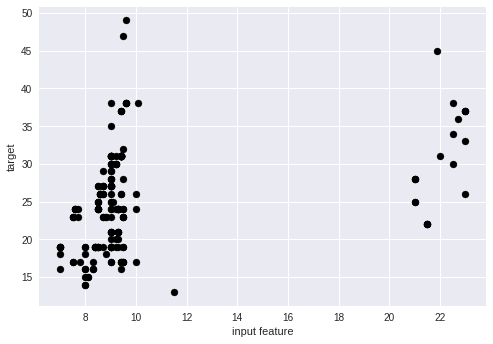

In [17]:
scatter_plot(car_data["compression-ratio"], car_data["city-mpg"])

**Would you expect a linear model to make a good prediction?**



---

No I would not expect a linear model to fit the data. There are to clusters of data that are separated by a big space. If we use a linear model just one you will predict in that space and that would not be the best prediction. In summary, you can use a linear model but it will not show the behavior of the data well.


## Exercise: Train a Linear Regression Model (1 point)

Tune the hyperparameters to train the best linear regression model you can to predict `city-mpg` from `compression-ratio`. **What do you observe?**

In [18]:
"""
Very briefly describe what you observe after training the model in this comment.
(There is no need to run this code block but it also won't hurt if you do).

I notice that there is a different behavior for the two ranges or 
clusters of the compression ratio. So we have the first cluster which is for 
lower compression ratio and the second cluster which is for higher compression
ratio. We see a gap between them you will see that our linear model will try to
fit the data. But as we observe in the calibration plot in the gap between 
the two clusters it will predict wrongly. There are 2 different behaviors and the 
linear model will not describe that behavior well.

"""

"\nVery briefly describe what you observe after training the model in this comment.\n(There is no need to run this code block but it also won't hurt if you do).\n\nI notice that there is a different behavior for the two ranges or \nclusters of the compression ratio. So we have the first cluster which is for \nlower compression ratio and the second cluster which is for higher compression\nratio. We see a gap between them you will see that our linear model will try to\nfit the data. But as we observe in the calibration plot in the gap between \nthe two clusters it will predict wrongly. There are 2 different behaviors and the \nlinear model will not describe that behavior well.\n\n"

Training model...
  Loss after period 00 : 18.684
  Loss after period 01 : 11.934
  Loss after period 02 : 7.457
  Loss after period 03 : 6.495
  Loss after period 04 : 6.171
  Loss after period 05 : 6.142
  Loss after period 06 : 6.133
  Loss after period 07 : 6.119
  Loss after period 08 : 6.100
  Loss after period 09 : 6.080
Final Loss (RMSE) on the training data: 6.080


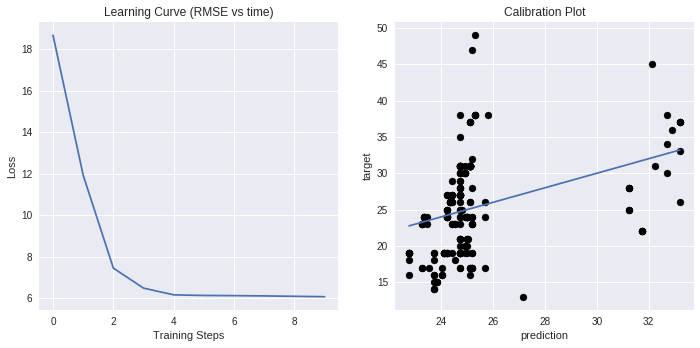

In [131]:
NUMERICAL_FEATURES = ["compression-ratio"]
CATEGORICAL_FEATURES = []
LABEL = "city-mpg"

# Create regression model using the define_regression_model procedure that we
# defined earlier.
linear_regressor = define_linear_regression_model(learning_rate = 0.0023)

train_model(linear_regressor, training_examples[NUMERICAL_FEATURES], 
training_examples[LABEL],
 steps=5000, batch_size=50)


## Exercise: Use a Bucketized Feature to Create a Better Model (2 points)

As you might have observed when looking at the scatter plot, there are two different behaviors happening: One with a low compression ratio, and another with a high compression ratio. So really we want to learn a separate offset (the bias) for these two regions.

A [Bucketized Column](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/bucketized_column) for a numerical feature is designed exactly for this situation.  Below we revise `construct_feature_columns` to introduce a bucketized feature column. Observe that since the bucketized features are binary (1 if in the bucket and 0 otherwise), adding the bucketized features allows the model to learn an independent bias for each bucket. If you also want to learn a slope for the model, you also still want to include the `compression_ratio` as a numerical feature.

Since the two bucketized features will have a value of 0 or 1, you might also want to do some linear scaling of compression ratio and then use 0.5 as your threshold.  If you were not able to get a linear scaling function to work in Lab 3, come to the office hours to get help writing this function if you decide that you'd like to use it in this lab.

**In the below code box we've provided the functions that you are likely to want to change. You'll need to make the needed changes in these functions.  You are welcome to add/remove functions as it fits your needs.**

In [0]:
# Make any needed changes to prepare_features
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
    feature: feature to be linear scaled
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  processed_features["compression-ratio"] = linear_scale(processed_features["compression-ratio"])
  ## Add whatever processing you'd like to use here.   
  ##for feature in feature_names:
  ##  processed_features[feature] = linear_scale(processed_features[feature])
  return processed_features

# Generate the training examples with your revised version of prepare_features
training_examples = prepare_features(car_data)

# Below, we modify construct_feature_columns to use compression_ratio, a
# bucketized feature for compression_ratio with two buckets using the provided
# threshold. Make sure that the threshold choice is appropriate for whatever
# feature processing you choose to use.

threshold =  0.5

def construct_feature_columns():
  """Construct the TensorFlow feature columns.

  Returns:
    A set of feature columns
  """
  compression_ratio = tf.contrib.layers.real_valued_column("compression-ratio")    
  bucketized_compression_ratio = tf.contrib.layers.bucketized_column(
      compression_ratio, [threshold])
  
  return set([compression_ratio, bucketized_compression_ratio])

### Now Train a Model

Once you've completed the changes above you can train the model.

Training model...
  Loss after period 00 : 6.021
  Loss after period 01 : 5.864
  Loss after period 02 : 5.790
  Loss after period 03 : 5.754
  Loss after period 04 : 5.740
  Loss after period 05 : 5.736
  Loss after period 06 : 5.729
  Loss after period 07 : 5.726
  Loss after period 08 : 5.728
  Loss after period 09 : 5.726
Final Loss (RMSE) on the training data: 5.726


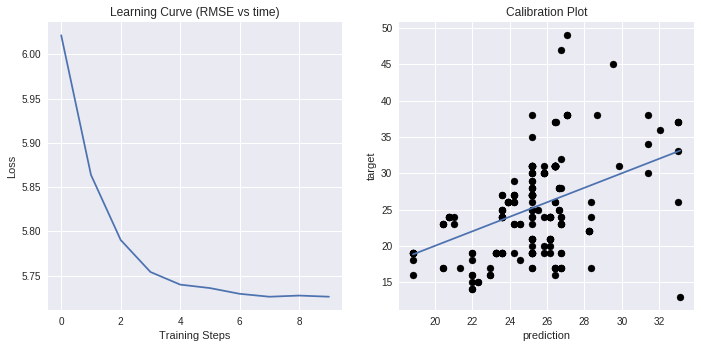

In [21]:
# Putting an empty categorical feature to generate a calibration plot instead
# of a scatter plot.
NUMERICAL_FEATURES = ["compression-ratio"]
CATEGORICAL_FEATURES = [""]
LABEL = "city-mpg"

LEARNING_RATE = 0.01
BATCH_SIZE = 50
STEPS = 15000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor,
                               training_examples[NUMERICAL_FEATURES],
                               training_examples[LABEL],
                               batch_size=BATCH_SIZE, steps=STEPS)

### Look at the Model Weights ###
If you ever want to see the weights stored in a model you can use the `get_variable_names` method.  Below is a code box that prints the weights trained in this model.

In [102]:
w = linear_regressor.get_variable_value("linear/linear_model/compression-ratio/weights")[0]
w_low = linear_regressor.get_variable_value("linear/linear_model/compression-ratio_bucketized/weights")[0]
w_high = linear_regressor.get_variable_value("linear/linear_model/compression-ratio_bucketized/weights")[1]
b = linear_regressor.get_variable_value("linear/linear_model/bias_weights")
print("weight for compression ratio:", w)
print("weight for compression ratio small bucket:", w_low)
print("weight for compression ratio large bucket:", w_high)
print("weight for model bias:", b)

weight for compression ratio: [50.861748]
weight for compression ratio small bucket: [18.497728]
weight for compression ratio large bucket: [-18.1749]
weight for model bias: [0.32282463]


## Exercise: Understand How to Make Predictions With This Model (1 point)##

For the model you just trained there are 3 variables:
* $x$ the `compression_ratio`
* $x_{low}$ the value for the bucket corresponding to low compression ratio that is 1 if the compression ratio is less than the threshold and 0 otherwise.
* $x_{high}$ the value for the bucket corresponding to high compression ratio that is 1 if the compression ratio is above the threshold and 0 otherwise.

When training the model there are 4 weights learned

*  $w$ the weight for `compression-ratio`
*  $w_{low}$ the weight for the bucket corresponding to low compression ratio
*  $w_{high}$ weight for the bucket corresponding to high compression ratio 
*  $b$ the bias

So the prediction made by the trained model for an example will be: $w * x + w_{low} * x_{low} + w_{high} * x_{high} + b$.

For this task, answer the following four questions.
* A) What is the prediction of your model when the original compression ratio is 20?  Remember to apply any feature normalization you did to this input value.
* B) What is the prediction of your model when the original compression ratio is 5?
* C) Derive a formula (simplified as much as you can) for the predicted `city-mpg` when the compression ratio  $x$ is less than the threshold.
* D) Derive a formula (simplified as much as you can) for the predicted `city-mpg` when the compression ratio $x$ is greater than the threshold.


In [0]:
"""
In order to answer the questions above I made a function that is calculating given 
the original compression ratio the prediction. Using the equation given above.

A. For the original compression-ratio of 20 my model will predict 23.473093. This
  taking into account the linear scaling of the data.

B. For the original compression-ratio of 5 my model will predict 12.462834.as_integer_ratio

C. 
    Step 1. y = w*x + w_low*x_low + w_high*x_high + b
    Step 2. y = w*x + w_low*1 + w_high*0 + b -> This because low compression ratio that is 1 if the compression ratio is less than the threshold and 0 otherwise.
    Step 3. y = w*x + w_low + b -> Let's say c = w_low+b
    Step 4. y = w*x + c

D. 
    Step 1. y = w*x + w_low*x_low + w_high*x_high + b
    Step 2. y = w*x + w_low*0 + w_high*1 + b -> This because high compression ratio that is 1 if the compression ratio is above than the threshold and 0 otherwise.
    Step 3. y = w*x + w_high + b -> Let's say c = w_high+b
    Step 4. y = w*x + c
"""

In [0]:

def calculatePrediction(x):
  old_compression = car_data["compression-ratio"]
  old_com_min = old_compression.min()
  old_com_max = old_compression.max()
  linear_conversion = ((x - old_com_min)/(old_com_max - old_com_min))
  if(linear_conversion < threshold):
    low_x = 1
    high_x = 0
  
  else:
    low_x = 0
    high_x = 1
  
  prediction = w * linear_conversion + w_low * low_x + w_high * high_x + b
  return prediction



In [123]:

print("A. What is the prediction of your model when the original compression ratio is 20? Remember to apply any feature normalization you did to this input value. " )
print( calculatePrediction(20))

print("B. What is the prediction of your model when the original compression ratio is 5? " )
print( calculatePrediction(5))

print("C. Derive a formula (simplified as much as you can) for the predicted city-mpg when the compression ratio  𝑥  is less than the threshold.")
print("Step 1. y = w*x + w_low*x_low + w_high*x_high + b")
print("Step 2. y = w*x + w_low*1 + w_high*0 + b -> This because low compression ratio that is 1 if the compression ratio is less than the threshold and 0 otherwise.")
print("Step 3. y = w*x + w_low + b -> Let's say c = w_low+b")
print("Step 4. y = w*x + c")

print("C. Derive a formula (simplified as much as you can) for the predicted city-mpg when the compression ratio  𝑥  is greater than the threshold.")
print("Step 1. y = w*x + w_low*x_low + w_high*x_high + b")
print("Step 2. y = w*x + w_low*0 + w_high*1 + b -> This because high compression ratio that is 1 if the compression ratio is above than the threshold and 0 otherwise.")
print("Step 3. y = w*x + w_high + b -> Let's say c = w_high+b")
print("Step 4. y = w*x + c")

A. What is the prediction of your model when the original compression ratio is 20? Remember to apply any feature normalization you did to this input value. 
[23.473093]
B. What is the prediction of your model when the original compression ratio is 5? 
[12.462834]
C. Derive a formula (simplified as much as you can) for the predicted city-mpg when the compression ratio  𝑥  is less than the threshold.
Step 1. y = w*x + w_low*x_low + w_high*x_high + b
Step 2. y = w*x + w_low*1 + w_high*0 + b -> This because low compression ratio that is 1 if the compression ratio is less than the threshold and 0 otherwise.
Step 3. y = w*x + w_low + b -> Let's say c = w_low+b
Step 4. y = w*x + c
C. Derive a formula (simplified as much as you can) for the predicted city-mpg when the compression ratio  𝑥  is greater than the threshold.
Step 1. y = w*x + w_low*x_low + w_high*x_high + b
Step 2. y = w*x + w_low*0 + w_high*1 + b -> This because high compression ratio that is 1 if the compression ratio is above th

## Exercise: Draw a Scatter Plot Showing the Predictions of Your Model (1 point)##

Unlike the scatter plots we've seen before, with the bucketized feature you will have a different linear model in the region for each bucket.  Here you are going to draw the model you trained with two buckets for `compression-ratio`. You can just put direct code to do this.  There is no need to modify `scatter_plot` but rather just use that code to guide you here where you are going to draw one line segment from x_min to your threshold for the bucketized feature and a second line segment going from your threshold to x_max.  We've got you started.

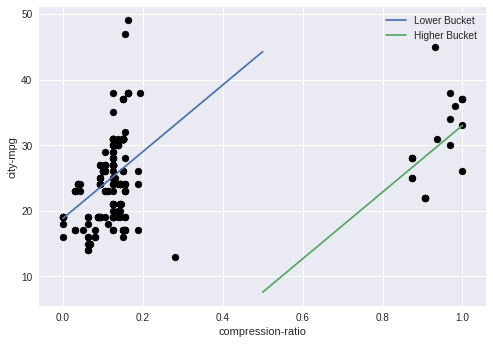

In [127]:
# Generate the scatter plot
x = training_examples["compression-ratio"]
y = training_examples["city-mpg"]
plt.ylabel("city-mpg")
plt.xlabel("compression-ratio")
plt.scatter(x, y, color='black', label="")

x_min = x.min()
x_max = x.max()

y_min = w * x_min + w_low * 1 + w_high * 0 + b
y_max = w * threshold + w_low * 1 + w_high * 0 + b
plt.plot([x_min, threshold], [y_min,y_max],label='Lower Bucket')

y_min_2 = w * threshold + w_low * 0 + w_high * 1 + b
y_max_2 = w * x_max + w_low * 0 + w_high * 1 + b
plt.plot([threshold,x_max], [y_min_2, y_max_2], label='Higher Bucket')
plt.legend()
plt.show()
